In [114]:
import pandas as pd

# Load the dataset
file_path = "C:/Users/thano/Downloads/archive/loan_data.csv"  # Update the path if necessary
loan_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(loan_data.head())

# Check for missing values
missing_values = loan_data.isnull().sum()
print("\nMissing Values:\n", missing_values)


   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561  

In [116]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('loan_database_normalized.db')
cursor = conn.cursor()

# Step 1: Define the schema for the normalized database
cursor.executescript("""
-- Drop tables if they already exist
DROP TABLE IF EXISTS Person;
DROP TABLE IF EXISTS Loan;
DROP TABLE IF EXISTS CreditHistory;

-- Create Person table
CREATE TABLE Person (
    person_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_age INTEGER,
    person_gender TEXT,
    person_education TEXT,
    person_income REAL,
    person_emp_exp INTEGER,
    person_home_ownership TEXT
);

-- Create Loan table
CREATE TABLE Loan (
    loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    loan_amnt REAL,
    loan_intent TEXT,
    loan_int_rate REAL,
    loan_percent_income REAL,
    loan_status INTEGER,
    FOREIGN KEY (person_id) REFERENCES Person(person_id)
);

-- Create CreditHistory table
CREATE TABLE CreditHistory (
    person_id INTEGER PRIMARY KEY,
    cb_person_cred_hist_length INTEGER,
    credit_score INTEGER,
    previous_loan_defaults_on_file TEXT,
    FOREIGN KEY (person_id) REFERENCES Person(person_id)
);
""")
conn.commit()

# Step 2: Populate the Person table
person_df = loan_data[['person_age', 'person_gender', 'person_education', 
                       'person_income', 'person_emp_exp', 'person_home_ownership']].drop_duplicates()
person_df.reset_index(drop=True, inplace=True)
person_df.index += 1  # Generate person_id
person_df['person_id'] = person_df.index

# Insert data into Person table
person_df.to_sql('Person', conn, if_exists='append', index=False)

# Step 3: Populate the CreditHistory table
credit_history_df = loan_data[['cb_person_cred_hist_length', 
                                'credit_score', 'previous_loan_defaults_on_file']].drop_duplicates()
credit_history_df.reset_index(drop=True, inplace=True)
credit_history_df.index += 1  # Generate person_id
credit_history_df['person_id'] = credit_history_df.index

# Insert data into CreditHistory table
credit_history_df.to_sql('CreditHistory', conn, if_exists='append', index=False)

# Step 4: Populate the Loan table
loan_df = loan_data[['loan_amnt', 'loan_intent', 'loan_int_rate', 
                     'loan_percent_income', 'loan_status']].copy()
loan_df.reset_index(drop=True, inplace=True)
loan_df.index += 1  # Generate loan_id
loan_df['loan_id'] = loan_df.index
loan_df['person_id'] = loan_df.index  # Assuming one-to-one for simplicity

# Insert data into Loan table
loan_df.to_sql('Loan', conn, if_exists='append', index=False)

# Step 5: Verify the tables
print("Person Table Sample:")
print(pd.read_sql_query("SELECT * FROM Person LIMIT 5", conn))

print("\nCreditHistory Table Sample:")
print(pd.read_sql_query("SELECT * FROM CreditHistory LIMIT 5", conn))

print("\nLoan Table Sample:")
print(pd.read_sql_query("SELECT * FROM Loan LIMIT 5", conn))

# Close the connection
conn.close()


Person Table Sample:
   person_id  person_age person_gender person_education  person_income  \
0          1          22        female           Master        71948.0   
1          2          21        female      High School        12282.0   
2          3          25        female      High School        12438.0   
3          4          23        female         Bachelor        79753.0   
4          5          24          male           Master        66135.0   

   person_emp_exp person_home_ownership  
0               0                  RENT  
1               0                   OWN  
2               3              MORTGAGE  
3               0                  RENT  
4               1                  RENT  

CreditHistory Table Sample:
   person_id  cb_person_cred_hist_length  credit_score  \
0          1                           3           561   
1          2                           2           504   
2          3                           3           635   
3          4         

In [118]:
conn = sqlite3.connect('loan_database_normalized.db')
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)
table_name = 'Person'  # Replace with your table name
schema = pd.read_sql_query(f"PRAGMA table_info({table_name});", conn)
print(schema)


              name
0  sqlite_sequence
1           Person
2             Loan
3    CreditHistory
   cid                   name     type  notnull dflt_value  pk
0    0              person_id  INTEGER        0       None   1
1    1             person_age  INTEGER        0       None   0
2    2          person_gender     TEXT        0       None   0
3    3       person_education     TEXT        0       None   0
4    4          person_income     REAL        0       None   0
5    5         person_emp_exp  INTEGER        0       None   0
6    6  person_home_ownership     TEXT        0       None   0


In [120]:
query = """
SELECT 
    p.person_age,
    p.person_gender,
    p.person_education,
    p.person_income,
    p.person_emp_exp,
    p.person_home_ownership,
    l.loan_amnt,
    l.loan_intent,
    l.loan_int_rate,
    l.loan_percent_income,
    l.loan_status,
    c.cb_person_cred_hist_length,
    c.credit_score,
    c.previous_loan_defaults_on_file
FROM Person p
JOIN Loan l ON p.person_id = l.person_id
JOIN CreditHistory c ON p.person_id = c.person_id;
"""

# Fetch data into Pandas DataFrame
joined_data = pd.read_sql_query(query, conn)
print("\nJoined Data:")
print(joined_data.head())



Joined Data:
   person_age person_gender person_education  person_income  person_emp_exp  \
0          22        female           Master        71948.0               0   
1          21        female      High School        12282.0               0   
2          25        female      High School        12438.0               3   
3          23        female         Bachelor        79753.0               0   
4          24          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  loan_status  cb_person_cred_hist_length  credit_score  \
0                 0.49            1    

In [122]:


from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = joined_data.drop(columns=['loan_status'])  # Features
y = joined_data['loan_status']  # Target

# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display train/test split details
print("\nTrain/Test Split Details:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Target distribution in training set:\n{y_train.value_counts()}")
print(f"Target distribution in test set:\n{y_test.value_counts()}")



Train/Test Split Details:
Training set size: 5308
Test set size: 1328
Target distribution in training set:
loan_status
0    3845
1    1463
Name: count, dtype: int64
Target distribution in test set:
loan_status
0    962
1    366
Name: count, dtype: int64


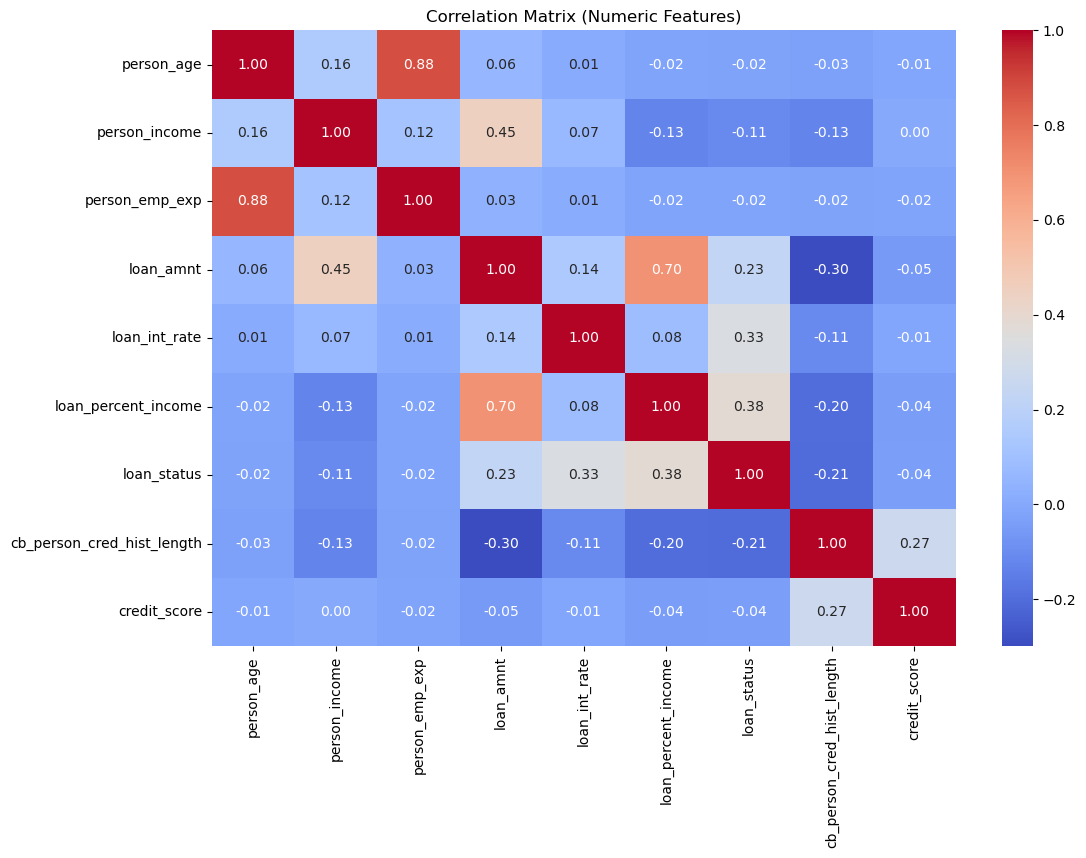


Missing Values:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
loan_status                       0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
dtype: int64

Non-Numeric Data Summary:
       person_gender person_education person_home_ownership loan_intent  \
count           6636             6636                  6636        6636   
unique             2                5                     4           6   
top             male         Bachelor                  RENT   EDUCATION   
freq            3644             2018                  4331        1509   

       previous_loan_defaults_on_file  
count                  

In [124]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Reconnect to the SQLite database
conn = sqlite3.connect('loan_database_normalized.db')

# Step 2: SQL query to fetch joined data
query = """
SELECT 
    p.person_age,
    p.person_gender,
    p.person_education,
    p.person_income,
    p.person_emp_exp,
    p.person_home_ownership,
    l.loan_amnt,
    l.loan_intent,
    l.loan_int_rate,
    l.loan_percent_income,
    l.loan_status,
    c.cb_person_cred_hist_length,
    c.credit_score,
    c.previous_loan_defaults_on_file
FROM Person p
JOIN Loan l ON p.person_id = l.person_id
JOIN CreditHistory c ON p.person_id = c.person_id;
"""

# Fetch data into a Pandas DataFrame
joined_data = pd.read_sql_query(query, conn)

# Step 3: Data exploration

# Filter for numeric data
numeric_data = joined_data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# Analyze non-numeric columns
non_numeric_data = joined_data.select_dtypes(exclude=['number'])
non_numeric_summary = non_numeric_data.describe(include='all')

# Check for missing values
missing_values = joined_data.isnull().sum()

# Generate observations and cleanup tasks
observations = {
    "missing_values": missing_values[missing_values > 0].to_dict(),
    "correlation_analysis": correlation_matrix.to_dict(),
    "non_numeric_summary": non_numeric_summary.to_dict(),
}

# Display results
print("\nMissing Values:")
print(missing_values)

print("\nNon-Numeric Data Summary:")
print(non_numeric_summary)

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Observations
print("\nObservations and Suggested Cleanup Tasks:")
print(observations)


In [67]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
!pip install mlflow
import mlflow
import mlflow.sklearn

# Step 1: Data Preparation
# Assuming `joined_data` is the dataset with features and target
# Define features and target
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_features),
        ("num_minmax", MinMaxScaler(), numeric_features),
        ("log_transform", FunctionTransformer(np.log1p, validate=True), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 3: Define the Pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

# Step 4: Enable MLflow Logging
mlflow.set_experiment("Loan_Status_Experiment")
mlflow.start_run(run_name="Experiment #1 - Logistic Regression")

# Step 5: Cross Validation
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=10, scoring="f1", return_train_score=True
)

# Log cross-validation results
mlflow.log_metric("cv_mean_f1", np.mean(cv_results["test_score"]))
mlflow.log_metric("cv_std_f1", np.std(cv_results["test_score"]))

# Step 6: Train on Full Training Data and Evaluate
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Compute Metrics
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Log metrics and model
mlflow.log_metric("f1_train", f1_train)
mlflow.log_metric("f1_test", f1_test)
mlflow.log_metric("TP", conf_matrix[1, 1])
mlflow.log_metric("TN", conf_matrix[0, 0])
mlflow.log_metric("FP", conf_matrix[0, 1])
mlflow.log_metric("FN", conf_matrix[1, 0])

mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")

# End MLflow Run
mlflow.end_run()

# Step 7: Print Results
print("Cross-validation F1 Score - Mean:", np.mean(cv_results["test_score"]))
print("Cross-validation F1 Score - Std:", np.std(cv_results["test_score"]))
print("F1 Score on Training Data:", f1_train)
print("F1 Score on Test Data:", f1_test)
print("Confusion Matrix on Test Data:")
print(conf_matrix)


2024/12/20 01:45:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Cross-validation F1 Score - Mean: 0.6406094854102846
Cross-validation F1 Score - Std: 0.03243870523368671
F1 Score on Training Data: 0.6455646737006643
F1 Score on Test Data: 0.631578947368421
Confusion Matrix on Test Data:
[[912  50]
 [174 192]]


In [126]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os

# Step 1: Set up MLflow Configuration for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment")

# Step 2: Data Preparation
# Ensure `joined_data` is loaded properly before running this code
# Example of loading your dataset if needed:
# joined_data = pd.read_csv("path_to_your_data.csv")

X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Define Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 4: Define Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

# Step 5: Iterate over Models
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"Experiment #2 - {model_name}"):
        # Create pipeline
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", model),
            ]
        )

        # Perform Cross-Validation
        cv_results = cross_validate(
            pipeline, X_train, y_train, cv=10, scoring="f1", return_train_score=True
        )

        # Log cross-validation metrics
        mlflow.log_metric("cv_mean_f1", np.mean(cv_results["test_score"]))
        mlflow.log_metric("cv_std_f1", np.std(cv_results["test_score"]))

        # Train and Evaluate on Full Training Data
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline


🏃 View run Experiment #2 - Logistic Regression at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0/runs/1306bb3e58e04408826af4161f4ed9c7
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0
🏃 View run Experiment #2 - Ridge Classifier at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0/runs/7ad9682d51e140008bdf5541c5c18c3f
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0
🏃 View run Experiment #2 - Random Forest at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0/runs/49eb260ac3004f969e4ea85ce9040e3a
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0


C:\Users\thano\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thano\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thano\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thano\anaconda3\Lib\site-packages\

🏃 View run Experiment #2 - XGBClassifier at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0/runs/597cb685b6f24c6386002ae792f83831
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0


In [127]:
import mlflow
import os

# Set MLflow Tracking URI to your DagsHub repository
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")

# Set DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"

# Start Experiment
mlflow.set_experiment("Loan_Status_Experiment")

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("max_depth", 5)

    # Log metrics
    mlflow.log_metric("accuracy", 0.92)
    mlflow.log_metric("f1_score", 0.88)

    # Log model (example using sklearn)
    from sklearn.linear_model import LogisticRegression
    import pickle

    # Example model
    model = LogisticRegression()
    # Save model to a file
    with open("model.pkl", "wb") as f:
        pickle.dump(model, f)

    # Log the saved model
    mlflow.log_artifact("model.pkl")

    # End the run
    mlflow.end_run()



🏃 View run upbeat-mink-665 at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0/runs/f6996106ac40412a85ace70fd660403e
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/0


In [85]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os

# Step 1: Set up MLflow Configuration
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment - Feature Engineering")

# Step 2: Data Preparation
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Step 3: Feature Engineering Function
def add_new_features(X):
    X = X.copy()
    X["income_to_loan_ratio"] = X["person_income"] / X["loan_amnt"]
    X["loan_to_employment"] = X["loan_amnt"] / (X["person_emp_exp"] + 1)  # Avoid division by zero
    X["interest_income_product"] = X["loan_int_rate"] * X["person_income"]
    return X

# Apply feature engineering
X = add_new_features(X)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Define Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 6: Model Pipeline
model = LogisticRegression(random_state=42, max_iter=1000)
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)

# Step 7: Enable MLflow Logging
with mlflow.start_run(run_name="Feature Engineering - Logistic Regression"):
    # Perform Cross-Validation
    cv_results = cross_validate(
        pipeline, X_train, y_train, cv=10, scoring="f1", return_train_score=True
    )

    # Log cross-validation metrics
    mlflow.log_metric("cv_mean_f1", np.mean(cv_results["test_score"]))
    mlflow.log_metric("cv_std_f1", np.std(cv_results["test_score"]))

    # Train and Evaluate on Full Training Data
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log evaluation metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("TP", conf_matrix[1, 1])
    mlflow.log_metric("TN", conf_matrix[0, 0])
    mlflow.log_metric("FP", conf_matrix[0, 1])
    mlflow.log_metric("FN", conf_matrix[1, 0])

    # Log the model
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline_with_features")

    # Log engineered features
    mlflow.log_param("engineered_features", ["income_to_loan_ratio", "loan_to_employment", "interest_income_product"])

    # Print Results
    print("Feature Engineering - Logistic Regression Results:")
    print(f"Cross-validation F1 Score - Mean: {np.mean(cv_results['test_score'])}")
    print(f"Cross-validation F1 Score - Std: {np.std(cv_results['test_score'])}")
    print(f"F1 Score on Training Data: {f1_train}")
    print(f"F1 Score on Test Data: {f1_test}")
    print("Confusion Matrix on Test Data:")
    print(conf_matrix)

    mlflow.end_run()



2024/12/20 07:46:09 INFO mlflow.tracking.fluent: Experiment with name 'Loan_Status_Experiment - Feature Engineering' does not exist. Creating a new experiment.
2024/12/20 07:46:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Engineering - Logistic Regression Results:
Cross-validation F1 Score - Mean: 0.6263058547912645
Cross-validation F1 Score - Std: 0.029338158100006114
F1 Score on Training Data: 0.6349331235247836
F1 Score on Test Data: 0.6151315789473685
Confusion Matrix on Test Data:
[[907  55]
 [179 187]]
🏃 View run Feature Engineering - Logistic Regression at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/1/runs/18c8fb1c836d4b21a89279e4924a89ec
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/1


In [128]:
from sklearn.feature_selection import VarianceThreshold
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment - Feature Selection")

# Step 2: Data Preparation
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Correlation Threshold
def correlation_threshold(X, threshold=0.9):
    # Select only numeric columns
    numeric_X = X.select_dtypes(include=["number"])
    
    # Compute the correlation matrix
    corr_matrix = numeric_X.corr().abs()
    
    # Identify highly correlated features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop correlated features from the original dataframe
    return X.drop(columns=to_drop)

X_train_corr = correlation_threshold(X_train)

# Step 4: Variance Threshold
def variance_threshold(X, threshold=0.01):
    numeric_X = X.select_dtypes(include=["number"])
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(numeric_X)
    selected_features = numeric_X.columns[selector.get_support()]
    return X[selected_features]

X_train_var = variance_threshold(X_train)

# Step 5: Feature Importance (Random Forest)
def feature_importance(X, y, num_features=10):
    numeric_X = X.select_dtypes(include=["number"])
    model = RandomForestClassifier(random_state=42)
    model.fit(numeric_X, y)
    importances = model.feature_importances_
    feature_indices = np.argsort(importances)[-num_features:]
    selected_features = numeric_X.columns[feature_indices]
    return X[selected_features]

X_train_imp = feature_importance(X_train_corr, y_train)

# Step 6: Logging to MLflow
for method, X_train_selected in zip(
    ["Correlation Threshold", "Variance Threshold", "Feature Importance"],
    [X_train_corr, X_train_var, X_train_imp],
):
    with mlflow.start_run(run_name=f"Feature Selection - {method}"):
        # Define Preprocessing
        numeric_features = X_train_selected.select_dtypes(include=["number"]).columns.tolist()
        categorical_features = X_train_selected.select_dtypes(include=["object", "category"]).columns.tolist()

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), numeric_features),
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ]
        )

        # Create Pipeline
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
            ]
        )

        # Perform Cross-Validation
        cv_results = cross_validate(
            pipeline, X_train_selected, y_train, cv=10, scoring="f1", return_train_score=True
        )

        # Train and Evaluate on Full Training Data
        pipeline.fit(X_train_selected, y_train)
        X_test_selected = X_test[X_train_selected.columns]
        y_pred_train = pipeline.predict(X_train_selected)
        y_pred_test = pipeline.predict(X_test_selected)

        # Calculate Metrics
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        conf_matrix = confusion_matrix(y_test, y_pred_test)

        # Log metrics
        mlflow.log_metric("cv_mean_f1", np.mean(cv_results["test_score"]))
        mlflow.log_metric("cv_std_f1", np.std(cv_results["test_score"]))
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("TP", conf_matrix[1, 1])
        mlflow.log_metric("TN", conf_matrix[0, 0])
        mlflow.log_metric("FP", conf_matrix[0, 1])
        mlflow.log_metric("FN", conf_matrix[1, 0])

        # Log parameters
        mlflow.log_param("selected_features", X_train_selected.columns.tolist())
        mlflow.log_param("method", method)

        # Log the model
        mlflow.sklearn.log_model(pipeline, f"logistic_regression_pipeline_{method.lower().replace(' ', '_')}")

        # Print Results
        print(f"\nFeature Selection - {method} Results:")
        print(f"Cross-validation F1 Score - Mean: {np.mean(cv_results['test_score'])}")
        print(f"Cross-validation F1 Score - Std: {np.std(cv_results['test_score'])}")
        print(f"F1 Score on Training Data: {f1_train}")
        print(f"F1 Score on Test Data: {f1_test}")
        print("Confusion Matrix on Test Data:")
        print(conf_matrix)

        mlflow.end_run()


2024/12/20 12:51:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Feature Selection - Correlation Threshold Results:
Cross-validation F1 Score - Mean: 0.628872604470408
Cross-validation F1 Score - Std: 0.027277086019731812
F1 Score on Training Data: 0.6353677621283255
F1 Score on Test Data: 0.632952691680261
Confusion Matrix on Test Data:
[[909  53]
 [172 194]]
🏃 View run Feature Selection - Correlation Threshold at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2/runs/c9de5deaded343c497b5f4f181924106
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2


2024/12/20 12:51:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Feature Selection - Variance Threshold Results:
Cross-validation F1 Score - Mean: 0.5496389965498508
Cross-validation F1 Score - Std: 0.030851132887736738
F1 Score on Training Data: 0.5518408802369869
F1 Score on Test Data: 0.5017667844522968
Confusion Matrix on Test Data:
[[904  58]
 [224 142]]
🏃 View run Feature Selection - Variance Threshold at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2/runs/2fe8c972f04b4ee8be2ed571768321b7
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2


2024/12/20 12:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Feature Selection - Feature Importance Results:
Cross-validation F1 Score - Mean: 0.5591828035556887
Cross-validation F1 Score - Std: 0.03751583401103938
F1 Score on Training Data: 0.5628840639082343
F1 Score on Test Data: 0.5326460481099656
Confusion Matrix on Test Data:
[[901  61]
 [211 155]]
🏃 View run Feature Selection - Feature Importance at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2/runs/ed1d72901ddd4dd1995811b93dc449cc
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/2


2024/12/20 12:52:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PCA Results:
Optimal Number of Components: 16
Cross-validation F1 Score - Mean: 0.6073306373073886
Cross-validation F1 Score - Std: 0.03616554921629028
F1 Score on Training Data: 0.6142172523961661
F1 Score on Test Data: 0.5676126878130217
Confusion Matrix on Test Data:
[[899  63]
 [196 170]]
🏃 View run Exp 5 - PCA at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/3/runs/9fba66bedbed47ea8fc1da0c605c1633
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/3


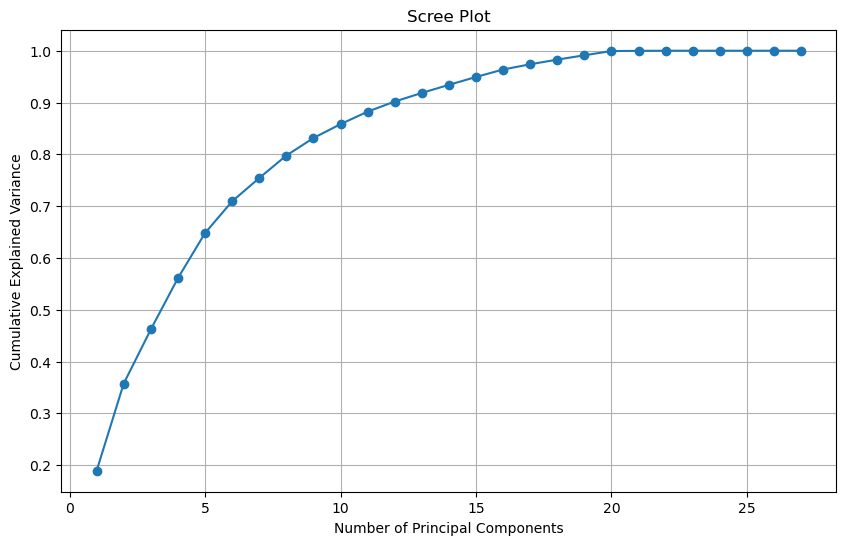

In [130]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import os

# Step 1: Set up MLflow Configuration
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment - PCA")

# Step 2: Data Preparation
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 4: Perform PCA
with mlflow.start_run(run_name="Exp 5 - PCA"):
    # Combine preprocessing with PCA
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("pca", PCA(n_components=None)),  # PCA with all components
        ]
    )
    
    # Fit PCA on the training set
    pipeline.fit(X_train)
    pca = pipeline.named_steps["pca"]
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Step 5: Scree Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.title("Scree Plot")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid()
    plt.savefig("scree_plot.png")
    mlflow.log_artifact("scree_plot.png")

    # Log PCA explained variance
    mlflow.log_param("pca_explained_variance", explained_variance.tolist())

    # Select the optimal number of components (e.g., 95% variance)
    n_components = np.argmax(explained_variance >= 0.95) + 1
    mlflow.log_param("optimal_components", n_components)

    # Step 6: Train Model with Reduced Features
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("pca", PCA(n_components=n_components)),
            ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
        ]
    )

    # Perform Cross-Validation
    cv_results = cross_validate(
        pipeline, X_train, y_train, cv=10, scoring="f1", return_train_score=True
    )

    # Log Cross-Validation Metrics
    mlflow.log_metric("cv_mean_f1", np.mean(cv_results["test_score"]))
    mlflow.log_metric("cv_std_f1", np.std(cv_results["test_score"]))

    # Train and Evaluate on Full Training Data
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log evaluation metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("TP", conf_matrix[1, 1])
    mlflow.log_metric("TN", conf_matrix[0, 0])
    mlflow.log_metric("FP", conf_matrix[0, 1])
    mlflow.log_metric("FN", conf_matrix[1, 0])

    # Log the model
    mlflow.sklearn.log_model(pipeline, "pca_pipeline_logistic_regression")

    # Print Results
    print("\nPCA Results:")
    print(f"Optimal Number of Components: {n_components}")
    print(f"Cross-validation F1 Score - Mean: {np.mean(cv_results['test_score'])}")
    print(f"Cross-validation F1 Score - Std: {np.std(cv_results['test_score'])}")
    print(f"F1 Score on Training Data: {f1_train}")
    print(f"F1 Score on Test Data: {f1_test}")
    print("Confusion Matrix on Test Data:")
    print(conf_matrix)

    mlflow.end_run()


In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os

# Step 1: Set up MLflow Configuration
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment - Custom Experiment")

# Step 2: Data Preparation
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 4: Base Models
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),  # Removed deprecated parameter
}

# Step 5: Generate Predictions for Stacking
meta_features_train = []
meta_features_test = []

with mlflow.start_run(run_name="Exp 6 - Stacked Ensemble"):
    for name, model in base_models.items():
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", model),
            ]
        )

        # Cross-validation predictions for stacking
        predictions_train = cross_val_predict(
            pipeline, X_train, y_train, cv=10, method="predict_proba"
        )[:, 1]  # Use probabilities for positive class
        pipeline.fit(X_train, y_train)
        predictions_test = pipeline.predict_proba(X_test)[:, 1]

        # Append predictions as meta-features
        meta_features_train.append(predictions_train)
        meta_features_test.append(predictions_test)

        # Log base model metrics
        y_pred_test = (predictions_test > 0.5).astype(int)
        f1_test = f1_score(y_test, y_pred_test)
        mlflow.log_metric(f"{name}_f1_test", f1_test)

    # Combine meta-features for stacking
    meta_features_train = np.array(meta_features_train).T
    meta_features_test = np.array(meta_features_test).T

    # Step 6: Train Meta-Model
    meta_model = LogisticRegression(random_state=42, max_iter=1000)
    meta_model.fit(meta_features_train, y_train)
    y_meta_pred_train = meta_model.predict(meta_features_train)
    y_meta_pred_test = meta_model.predict(meta_features_test)

    # Evaluate Meta-Model
    f1_train = f1_score(y_train, y_meta_pred_train)
    f1_test = f1_score(y_test, y_meta_pred_test)
    conf_matrix = confusion_matrix(y_test, y_meta_pred_test)

    # Log Metrics for Meta-Model
    mlflow.log_metric("meta_model_f1_train", f1_train)
    mlflow.log_metric("meta_model_f1_test", f1_test)
    mlflow.log_metric("TP", conf_matrix[1, 1])
    mlflow.log_metric("TN", conf_matrix[0, 0])
    mlflow.log_metric("FP", conf_matrix[0, 1])
    mlflow.log_metric("FN", conf_matrix[1, 0])

    # Log Meta-Model with Input Example
    mlflow.sklearn.log_model(
        meta_model,
        "stacked_meta_model",
        input_example=meta_features_train[:1],  # Added input example for reproducibility
    )

    # Print Results
    print("\nCustom Experiment - Stacked Ensemble Results:")
    print(f"Meta-Model F1 Score on Training Data: {f1_train}")
    print(f"Meta-Model F1 Score on Test Data: {f1_test}")
    print("Confusion Matrix on Test Data:")
    print(conf_matrix)

    mlflow.end_run()


Custom Experiment - Stacked Ensemble Results:
Meta-Model F1 Score on Training Data: 0.7840781073976718
Meta-Model F1 Score on Test Data: 0.7824726134585289
Confusion Matrix on Test Data:
[[939  23]
 [116 250]]
🏃 View run Exp 6 - Stacked Ensemble at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/4/runs/066bf0c6aee344ef92e06458088d17c4
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/4


In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os

# Step 1: Set up MLflow Configuration
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "keerthi583"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "c070a8ec84d0967e53e560a88863627e8a2de352"
mlflow.set_experiment("Loan_Status_Experiment - Hyperparameter Tuning")

# Step 2: Data Preparation
X = joined_data.drop(columns=["loan_status"])  # Features
y = joined_data["loan_status"]  # Target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Preprocessing
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Step 4: Define Models and Hyperparameters
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [50, 100, 200],
            "classifier__max_depth": [None, 10, 20],
            "classifier__min_samples_split": [2, 5, 10],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__max_depth": [3, 5, 7],
            "classifier__n_estimators": [50, 100, 200],
        },
    },
}

# Step 5: Grid Search and Logging in MLflow
for name, config in models.items():
    with mlflow.start_run(run_name=f"Exp 7 - {name} Hyperparameter Tuning"):
        # Create pipeline
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", config["model"]),
            ]
        )

        # Grid search
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=config["params"],
            scoring="f1",
            cv=10,
            verbose=1,
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)

        # Best parameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        # Predictions
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        # Evaluation
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        conf_matrix = confusion_matrix(y_test, y_pred_test)

        # Log Metrics
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("TP", conf_matrix[1, 1])
        mlflow.log_metric("TN", conf_matrix[0, 0])
        mlflow.log_metric("FP", conf_matrix[0, 1])
        mlflow.log_metric("FN", conf_matrix[1, 0])

        # Log Best Parameters
        mlflow.log_params(best_params)

        # Log the Model
        mlflow.sklearn.log_model(best_model, f"{name}_best_model")

        # Print Results
        print(f"\n{name} - Hyperparameter Tuning Results:")
        print(f"Best Parameters: {best_params}")
        print(f"F1 Score on Training Data: {f1_train}")
        print(f"F1 Score on Test Data: {f1_test}")
        print("Confusion Matrix on Test Data:")
        print(conf_matrix)

        mlflow.end_run()

Fitting 10 folds for each of 27 candidates, totalling 270 fits


2024/12/20 12:52:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random Forest - Hyperparameter Tuning Results:
Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
F1 Score on Training Data: 0.9518029275258836
F1 Score on Test Data: 0.7532051282051282
Confusion Matrix on Test Data:
[[939  23]
 [131 235]]
🏃 View run Exp 7 - Random Forest Hyperparameter Tuning at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/5/runs/fe9ac4e1262b46daa2c4effe4dd99929
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/5
Fitting 10 folds for each of 27 candidates, totalling 270 fits


2024/12/20 12:52:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



XGBoost - Hyperparameter Tuning Results:
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
F1 Score on Training Data: 0.9207630227439472
F1 Score on Test Data: 0.7719298245614035
Confusion Matrix on Test Data:
[[943  19]
 [124 242]]
🏃 View run Exp 7 - XGBoost Hyperparameter Tuning at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/5/runs/e1cce470d2894d949663033d1b76649a
🧪 View experiment at: https://dagshub.com/keerthi583/keerthi.mlflow/#/experiments/5


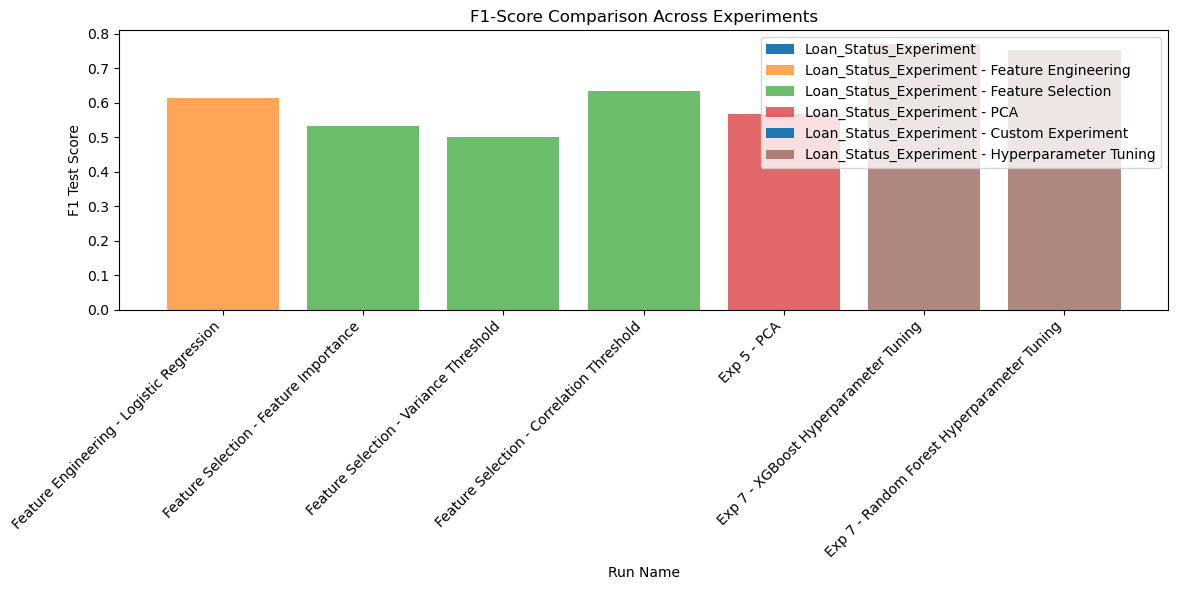

In [108]:
import mlflow
import matplotlib.pyplot as plt
import pandas as pd

# Set up MLflow Tracking URI
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")

# List of experiments to compare
experiments = [
    "Loan_Status_Experiment",
    "Loan_Status_Experiment - Feature Engineering",
    "Loan_Status_Experiment - Feature Selection",
    "Loan_Status_Experiment - PCA",
    "Loan_Status_Experiment - Custom Experiment",
    "Loan_Status_Experiment - Hyperparameter Tuning",
]

# Initialize data storage
results = []

# Retrieve metrics for all experiments
for experiment_name in experiments:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        for _, run in runs.iterrows():
            # Safely retrieve metrics
            f1_test = run.get("metrics.f1_test", None)
            f1_train = run.get("metrics.f1_train", None)
            results.append(
                {
                    "Experiment": experiment_name,
                    "Run Name": run.get("tags.mlflow.runName", "Unnamed Run"),
                    "F1 Test": f1_test,
                    "F1 Train": f1_train,
                }
            )

# Create a DataFrame for visualization
results_df = pd.DataFrame(results)

# Drop rows where F1 Test is missing
results_df = results_df.dropna(subset=["F1 Test"])

# Plot F1-score comparison
plt.figure(figsize=(12, 6))
for experiment in experiments:
    exp_data = results_df[results_df["Experiment"] == experiment]
    plt.bar(
        exp_data["Run Name"],
        exp_data["F1 Test"],
        label=experiment,
        alpha=0.7,
    )

plt.title("F1-Score Comparison Across Experiments")
plt.xlabel("Run Name")
plt.ylabel("F1 Test Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [136]:
import mlflow
import pandas as pd

# Set up MLflow Tracking URI
mlflow.set_tracking_uri("https://dagshub.com/keerthi583/keerthi.mlflow")

# List of experiments
experiments = [
    "Loan_Status_Experiment",
    "Loan_Status_Experiment - Feature Engineering",
    "Loan_Status_Experiment - Feature Selection",
    "Loan_Status_Experiment - PCA",
    "Loan_Status_Experiment - Custom Experiment",
    "Loan_Status_Experiment - Hyperparameter Tuning",
]

# Initialize data storage
results = []

# Retrieve metrics for all experiments
for experiment_name in experiments:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        for _, run in runs.iterrows():
            f1_test = run.get("metrics.f1_test", None)
            f1_train = run.get("metrics.f1_train", None)
            results.append(
                {
                    "Experiment": experiment_name,
                    "Run Name": run.get("tags.mlflow.runName", "Unnamed Run"),
                    "F1 Test": f1_test,
                    "F1 Train": f1_train,
                }
            )

# Create a DataFrame for analysis
results_df = pd.DataFrame(results)

# Drop rows with missing F1 Test scores
results_df = results_df.dropna(subset=["F1 Test"])

# Identify the best model based on F1 Test score
best_model_row = results_df.loc[results_df["F1 Test"].idxmax()]

print("Best Model Details:")
print(best_model_row)


Best Model Details:
Experiment    Loan_Status_Experiment - Hyperparameter Tuning
Run Name               Exp 7 - XGBoost Hyperparameter Tuning
F1 Test                                              0.77193
F1 Train                                            0.920763
Name: 24, dtype: object


In [134]:
import joblib

# Assuming `best_model` is the XGBoost model from the hyperparameter tuning
joblib.dump(best_model, "final_xgboost_model.joblib")
print("Model saved as final_xgboost_model.joblib")


Model saved as final_xgboost_model.joblib
